In [41]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import matplotlib.pyplot as plt
import os

# Research Question 2: Can Google Trends data predict whether trading volume will be high next week?

- Can lagged values of attention-related keyword indexes improve the accuracy of next-week trading volume forecasts?

- How does the predictive performance of attention data compare with baseline time series models (e.g., AR, ARIMA)?

- Is there cross-sectional variation in predictability across different types of stocks (e.g., ETFs, large caps, beginner-friendly tickers)?



To address Research Question 2, we investigate whether investor attention—quantified through Google Trends search volume indexes—can be used to predict short-term fluctuations in stock trading activity. Specifically, we test whether current or lagged values of attention indexes improve the accuracy of next-week trading volume forecasts across different types of stocks, including ETFs, large-cap firms, and beginner-targeted equities. Our approach involves constructing a supervised learning framework where lagged attention variables serve as predictors, and normalized trading volume in the following week is the target. We evaluate predictive performance using standard forecasting metrics such as Mean Squared Error (MSE) for continuous models, and optionally classification accuracy or AUC if trading volume is discretized into high/low categories. To contextualize the value of attention data, we compare its performance against traditional autoregressive baselines that rely only on past volume data. This setup allows us to determine not only whether attention contains forward-looking information, but also whether that information adds measurable forecasting power relative to historical price-and-volume-only models.

#### Code

In [51]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay
)

## Linear Regression Model

#### Code

In [16]:
# create lagged attention features and next-week volume target

merged_df = pd.read_excel("merged_df.xlsx")
# Copy to avoid modifying original
df = merged_df.copy()

# Initialize a result dictionary
model_results = {}

# Step 1: Shift attention features by 1 week (lag)
attention_cols = [col for col in df.columns if 'Attention_Index' in col]
for col in attention_cols:
    df[f'{col}_lag1'] = df[col].shift(1)

# Step 2: Create prediction target (next week's volume)
target_ticker = '2330.TW_Volume_norm'  # ← change this to any ticker you want to predict
df['target'] = df[target_ticker].shift(-1)

# Step 3: Drop rows with NaN (due to shifting)
df_model = df[[f'{col}_lag1' for col in attention_cols] + ['target']].dropna()

In [17]:
# Train/test split and fit regression model

# Step 1: Define X (features) and y (target)
X = df_model.drop(columns='target')
y = df_model['target']

# Step 2: Split data by time (70% train, 30% test)
split_idx = int(len(df_model) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Step 3: Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 4: Make predictions and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE on test set: {rmse:.4f}")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
model_results['Attention_Only_LR'] = rmse

RMSE on test set: 0.8349


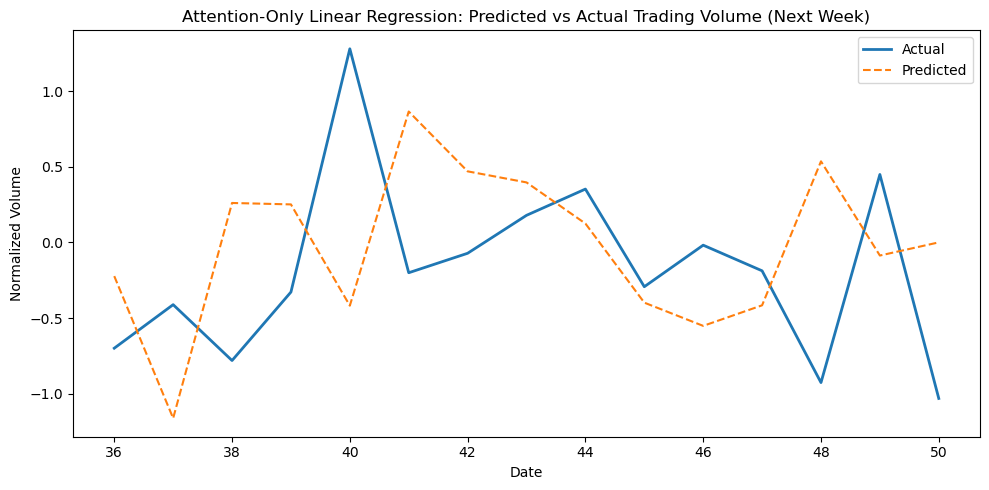

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', linestyle='--')
plt.title('Attention-Only Linear Regression: Predicted vs Actual Trading Volume (Next Week)')
plt.xlabel('Date')
plt.ylabel('Normalized Volume')
plt.legend()
plt.tight_layout()
plt.savefig("graphs/rq2_attention_lr_pred_vs_actual.png", dpi=300)
plt.show()

In [19]:
# Step 1: Create lagged volume feature (t-1) and target (t)
baseline_df = merged_df[[target_ticker]].copy()
baseline_df['lagged_volume'] = baseline_df[target_ticker].shift(1)
baseline_df['target'] = baseline_df[target_ticker].shift(-1)

# Step 2: Drop missing values
baseline_df = baseline_df.dropna()

# Step 3: Define features and target
X_base = baseline_df[['lagged_volume']]
y_base = baseline_df['target']

# Step 4: Time-based train/test split
split_idx = int(len(baseline_df) * 0.7)
Xb_train, Xb_test = X_base.iloc[:split_idx], X_base.iloc[split_idx:]
yb_train, yb_test = y_base.iloc[:split_idx], y_base.iloc[split_idx:]

# Step 5: Fit linear regression model
baseline_model = LinearRegression()
baseline_model.fit(Xb_train, yb_train)

# Step 6: Predict and evaluate
yb_pred = baseline_model.predict(Xb_test)
baseline_rmse = np.sqrt(mean_squared_error(yb_test, yb_pred))
print(f"Baseline RMSE (Lagged Volume): {baseline_rmse:.4f}")

# Step 7: Save RMSE
model_results['Volume_Only_LR'] = baseline_rmse

Baseline RMSE (Lagged Volume): 0.7557


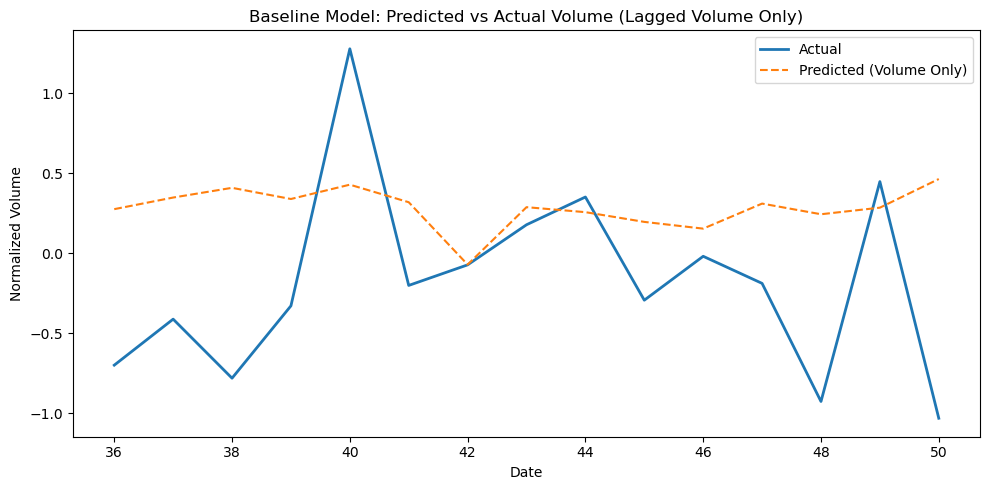

In [20]:
# Ensure output folder exists
os.makedirs("outputs", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(yb_test.index, yb_test.values, label='Actual', linewidth=2)
plt.plot(yb_test.index, yb_pred, label='Predicted (Volume Only)', linestyle='--')
plt.title('Baseline Model: Predicted vs Actual Volume (Lagged Volume Only)')
plt.xlabel('Date')
plt.ylabel('Normalized Volume')
plt.legend()
plt.tight_layout()
plt.savefig("graphs/rq2_volume_baseline_pred_vs_actual.png", dpi=300)
plt.show()

In [21]:
# Step 1: Copy and extend the existing df
df_combined = merged_df.copy()

# Step 2: Create lagged attention features
attention_cols = [col for col in df_combined.columns if 'Attention_Index' in col]
for col in attention_cols:
    df_combined[f'{col}_lag1'] = df_combined[col].shift(1)

# Step 3: Create lagged volume and target
df_combined['lagged_volume'] = df_combined[target_ticker].shift(1)
df_combined['target'] = df_combined[target_ticker].shift(-1)

# Step 4: Select features and drop missing values
combined_features = [f'{col}_lag1' for col in attention_cols] + ['lagged_volume']
df_combined_model = df_combined[combined_features + ['target']].dropna()

# Step 5: Define X and y
X_comb = df_combined_model[combined_features]
y_comb = df_combined_model['target']

# Step 6: Train/test split by time
split_idx = int(len(df_combined_model) * 0.7)
Xc_train, Xc_test = X_comb.iloc[:split_idx], X_comb.iloc[split_idx:]
yc_train, yc_test = y_comb.iloc[:split_idx], y_comb.iloc[split_idx:]

# Step 7: Fit model
combined_model = LinearRegression()
combined_model.fit(Xc_train, yc_train)

# Step 8: Predict and evaluate
yc_pred = combined_model.predict(Xc_test)
combined_rmse = np.sqrt(mean_squared_error(yc_test, yc_pred))
print(f"Combined Model RMSE (Attention + Volume): {combined_rmse:.4f}")

# Step 9: Save RMSE
model_results['Attention+Volume_LR'] = combined_rmse


Combined Model RMSE (Attention + Volume): 0.8354


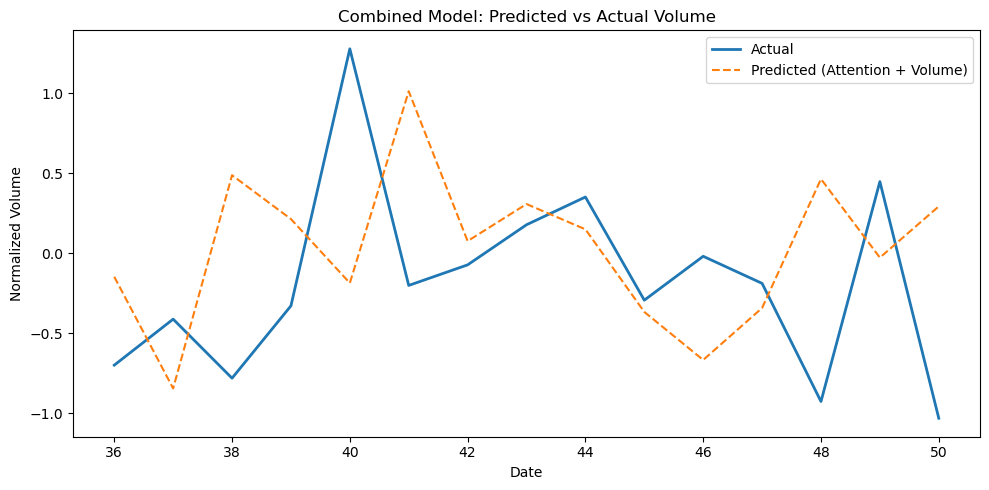

In [22]:
# Ensure output folder exists
os.makedirs("outputs", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(yc_test.index, yc_test.values, label='Actual', linewidth=2)
plt.plot(yc_test.index, yc_pred, label='Predicted (Attention + Volume)', linestyle='--')
plt.title('Combined Model: Predicted vs Actual Volume')
plt.xlabel('Date')
plt.ylabel('Normalized Volume')
plt.legend()
plt.tight_layout()
plt.savefig("graphs/rq2_combined_attention_volume_pred_vs_actual.png", dpi=300)
plt.show()

In [23]:
# Convert results dict to DataFrame
results_df = pd.DataFrame.from_dict(model_results, orient='index', columns=['RMSE'])
results_df = results_df.sort_values(by='RMSE')  # optional: sort from best to worst

# Display
print(results_df)

# Export to CSV
results_df.to_csv('outputs/rq2_model_rmse_comparison.csv')

                         RMSE
Volume_Only_LR       0.755662
Attention_Only_LR    0.834949
Attention+Volume_LR  0.835422


<Figure size 800x500 with 0 Axes>

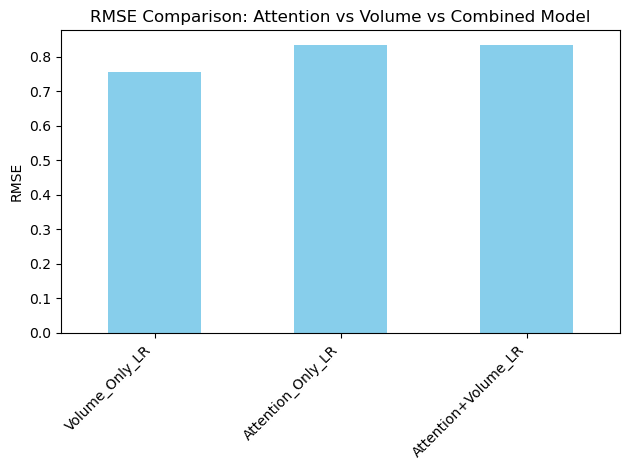

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
results_df.plot(kind='bar', legend=False, color='skyblue')
plt.title("RMSE Comparison: Attention vs Volume vs Combined Model")
plt.ylabel("RMSE")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("graphs/rq2_model_rmse_bar_chart.png", dpi=300)
plt.show()

### Linear Regression Model Comparison and Interpretation

The RMSE comparison reveals that the model using only lagged trading volume achieves the best predictive performance, with an RMSE of approximately 0.756. In contrast, the attention-only model performs worse, with an RMSE of 0.834, indicating that while investor attention data captures some relevant signals, it is less effective than historical volume data for forecasting next-week trading activity. Surprisingly, the combined model, which integrates both lagged attention and volume features, does not outperform the volume-only baseline—it produces an RMSE of 0.835, slightly worse than using attention alone. This suggests that the attention signals may introduce noise or multicollinearity when added alongside volume data, rather than offering additive predictive value in this linear setting. These results highlight the importance of benchmarking attention-based models against simple baselines and caution against assuming that more features always improve forecasting accuracy. Further exploration using nonlinear models or feature selection may help clarify whether attention data can enhance predictive power when used more selectively or interactively.










## Logistic Regression Model

#### Code

In [35]:
# Use df_model which already has lagged attention and target_class
attention_cls_df = df_model.copy()

# Step 1: Features and target
X_attn_cls = attention_cls_df.drop(columns=['target', 'target_class'])  # lagged attention features only
y_attn_cls = attention_cls_df['target_class']

# Step 2: Time-based train/test split
split_idx = int(len(attention_cls_df) * 0.7)
Xa_train, Xa_test = X_attn_cls.iloc[:split_idx], X_attn_cls.iloc[split_idx:]
ya_train, ya_test = y_attn_cls.iloc[:split_idx], y_attn_cls.iloc[split_idx:]

# Step 3: Train model
clf_attn = LogisticRegression()
clf_attn.fit(Xa_train, ya_train)
y_pred_attn = clf_attn.predict(Xa_test)
y_prob_attn = clf_attn.predict_proba(Xa_test)[:, 1]

# Step 4: Evaluate
acc_attn = accuracy_score(ya_test, y_pred_attn)
auc_attn = roc_auc_score(ya_test, y_prob_attn)
print(f"Attention-only Classifier - Accuracy: {acc_attn:.4f}, AUC: {auc_attn:.4f}")

Attention-only Classifier - Accuracy: 0.4667, AUC: 0.4444


In [32]:
# Create lagged volume and target class
df_volume_cls = merged_df[[target_ticker]].copy()
df_volume_cls['lagged_volume'] = df_volume_cls[target_ticker].shift(1)
df_volume_cls['target'] = df_volume_cls[target_ticker].shift(-1)

# Binary target: high vs low
threshold = df_volume_cls['target'].median()
df_volume_cls['target_class'] = (df_volume_cls['target'] > threshold).astype(int)

# Drop NaN
df_volume_cls = df_volume_cls.dropna()

# Split
X_vol = df_volume_cls[['lagged_volume']]
y_vol = df_volume_cls['target_class']
split_idx = int(len(df_volume_cls) * 0.7)
Xv_train, Xv_test = X_vol.iloc[:split_idx], X_vol.iloc[split_idx:]
yv_train, yv_test = y_vol.iloc[:split_idx], y_vol.iloc[split_idx:]

# Train and evaluate
clf_vol = LogisticRegression()
clf_vol.fit(Xv_train, yv_train)
y_pred_vol = clf_vol.predict(Xv_test)
y_prob_vol = clf_vol.predict_proba(Xv_test)[:, 1]

acc_vol = accuracy_score(yv_test, y_pred_vol)
auc_vol = roc_auc_score(yv_test, y_prob_vol)
print(f"Volume-only Classifier - Accuracy: {acc_vol:.4f}, AUC: {auc_vol:.4f}")


Volume-only Classifier - Accuracy: 0.4000, AUC: 0.2963


In [33]:
df_comb_cls = df_combined_model.copy()  # reuse from earlier combined regression

# Binary target
threshold = df_comb_cls['target'].median()
df_comb_cls['target_class'] = (df_comb_cls['target'] > threshold).astype(int)

# Split
X_comb_cls = df_comb_cls.drop(columns=['target', 'target_class'])
y_comb_cls = df_comb_cls['target_class']
split_idx = int(len(df_comb_cls) * 0.7)
Xcm_train, Xcm_test = X_comb_cls.iloc[:split_idx], X_comb_cls.iloc[split_idx:]
ycm_train, ycm_test = y_comb_cls.iloc[:split_idx], y_comb_cls.iloc[split_idx:]

# Train and evaluate
clf_comb = LogisticRegression()
clf_comb.fit(Xcm_train, ycm_train)
y_pred_comb = clf_comb.predict(Xcm_test)
y_prob_comb = clf_comb.predict_proba(Xcm_test)[:, 1]

acc_comb = accuracy_score(ycm_test, y_pred_comb)
auc_comb = roc_auc_score(ycm_test, y_prob_comb)
print(f"Combined Classifier - Accuracy: {acc_comb:.4f}, AUC: {auc_comb:.4f}")


Combined Classifier - Accuracy: 0.4667, AUC: 0.4444


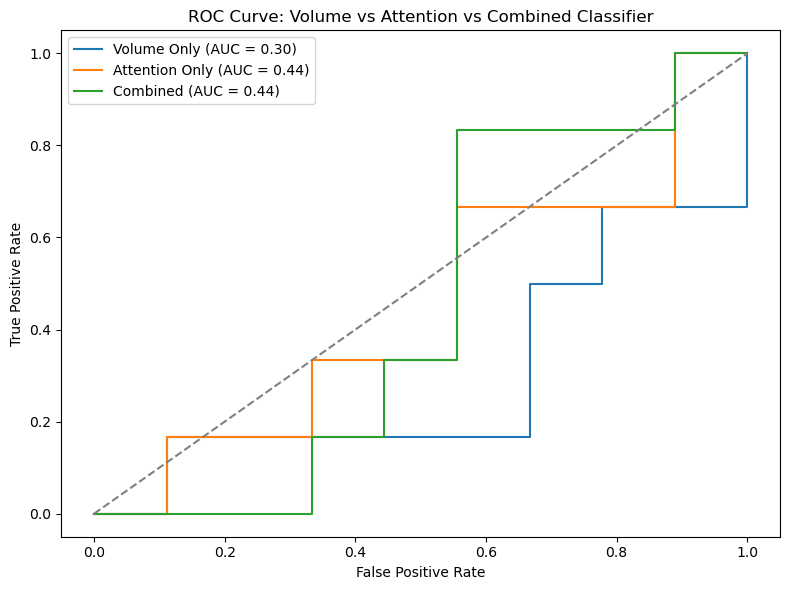

In [36]:
from sklearn.metrics import roc_curve

# Compute ROC curve
fpr_attn, tpr_attn, _ = roc_curve(ya_test, y_prob_attn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_vol, tpr_vol, label=f'Volume Only (AUC = {auc_vol:.2f})')
plt.plot(fpr_attn, tpr_attn, label=f'Attention Only (AUC = {auc_attn:.2f})')
plt.plot(fpr_comb, tpr_comb, label=f'Combined (AUC = {auc_comb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Volume vs Attention vs Combined Classifier')
plt.legend()
plt.tight_layout()
plt.savefig("graphs/rq2_classification_roc_all.png", dpi=300)
plt.show()

In [39]:
# Store results
classification_results = {
    'Volume_Only_LR': {'Accuracy': acc_vol, 'AUC': auc_vol},
    'Attention_Only_LR': {'Accuracy': acc_attn, 'AUC': auc_attn},
    'Attention+Volume_LR': {'Accuracy': acc_comb, 'AUC': auc_comb}
}

# Convert to DataFrame
classification_df = pd.DataFrame(classification_results).T
classification_df = classification_df.round(4)  # optional: round for readability

# Display
print(classification_df)
classification_df.to_csv("outputs/rq2_classification_model_summary.csv")

                     Accuracy     AUC
Volume_Only_LR         0.4000  0.2963
Attention_Only_LR      0.4667  0.4444
Attention+Volume_LR    0.4667  0.4444


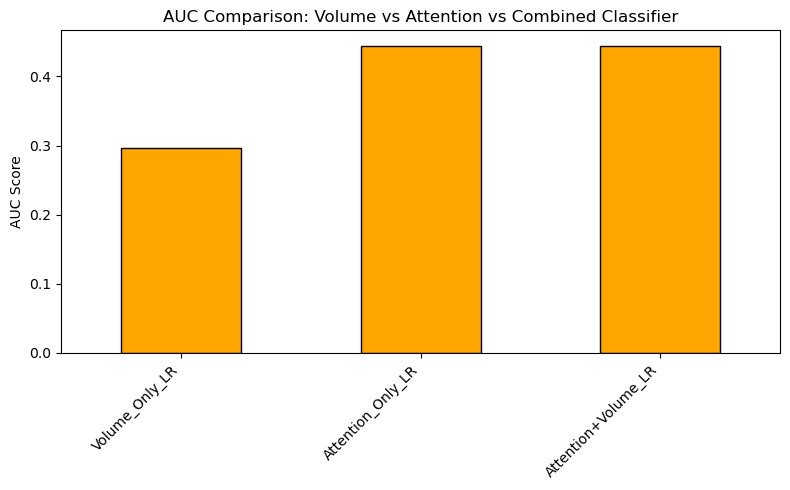

In [40]:
# Ensure output folder exists
os.makedirs("outputs", exist_ok=True)

# Plot AUC comparison
plt.figure(figsize=(8, 5))
classification_df['AUC'].plot(kind='bar', color='orange', edgecolor='black')
plt.title("AUC Comparison: Volume vs Attention vs Combined Classifier")
plt.ylabel("AUC Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("outputs/rq2_classification_auc_bar_chart.png", dpi=300)
plt.show()

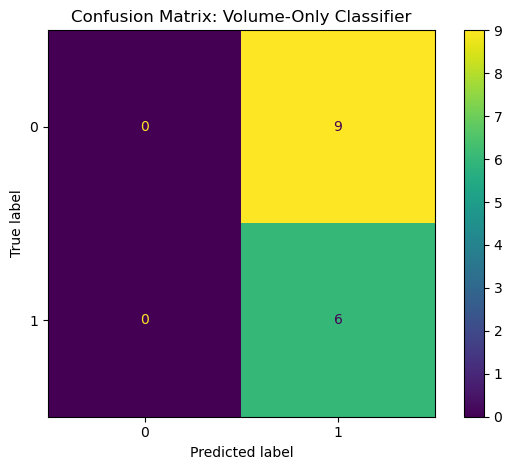

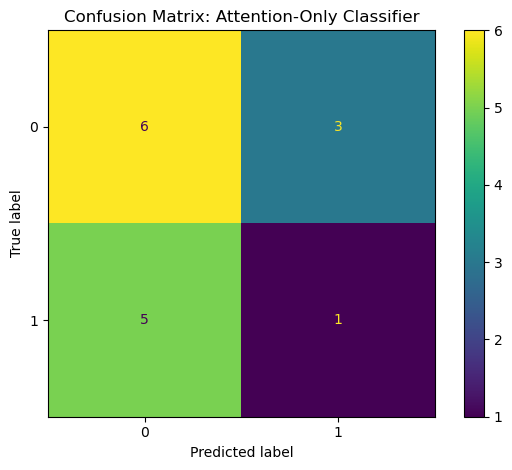

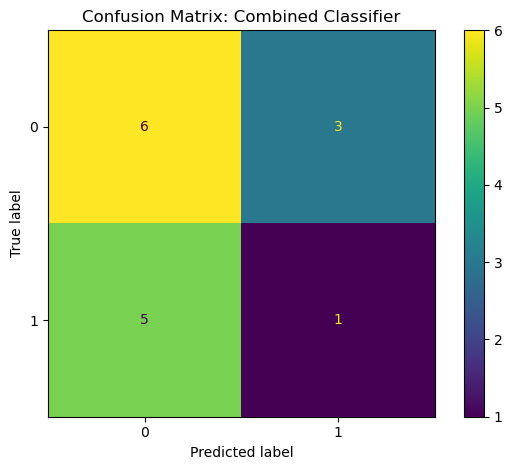

In [42]:
# Volume-only
cm_vol = confusion_matrix(yv_test, y_pred_vol)
disp_vol = ConfusionMatrixDisplay(confusion_matrix=cm_vol)
disp_vol.plot()
plt.title("Confusion Matrix: Volume-Only Classifier")
plt.tight_layout()
plt.savefig("graphs/rq2_conf_matrix_volume.png", dpi=300)
plt.show()

# Attention-only
cm_attn = confusion_matrix(ya_test, y_pred_attn)
disp_attn = ConfusionMatrixDisplay(confusion_matrix=cm_attn)
disp_attn.plot()
plt.title("Confusion Matrix: Attention-Only Classifier")
plt.tight_layout()
plt.savefig("graphs/rq2_conf_matrix_attention.png", dpi=300)
plt.show()

# Combined
cm_comb = confusion_matrix(ycm_test, y_pred_comb)
disp_comb = ConfusionMatrixDisplay(confusion_matrix=cm_comb)
disp_comb.plot()
plt.title("Confusion Matrix: Combined Classifier")
plt.tight_layout()
plt.savefig("graphs/rq2_conf_matrix_combined.png", dpi=300)
plt.show()

### Interpretation: Classification Models for Predicting High Trading Volume

The classification analysis reveals mixed performance across models, with none achieving particularly strong predictive power. Among the three logistic regression classifiers, the Attention-Only and Combined Attention+Volume models performed similarly, both reaching an AUC of 0.444 and an accuracy of 0.4667. This is only slightly above random guessing (accuracy = 0.5, AUC = 0.5) and indicates limited but slightly better-than-chance discriminative power.

In contrast, the Volume-Only model exhibited an AUC of 0.2963 and lower accuracy of 0.40, suggesting that recent volume movements alone may not be helpful—indeed, even counterproductive—for predicting next-week volume direction in this binary setting. This is further supported by its confusion matrix, which shows extreme imbalance: the model predicted almost all outcomes as “high volume” regardless of actual labels, failing to distinguish between classes.

The confusion matrices for both the Attention-Only and Combined classifiers show some variance in prediction but still struggle with false negatives—frequently misclassifying high-volume weeks as low. Notably, the Combined model did not improve upon the Attention-Only model, which implies that in a linear classification setting, attention data alone captures most of the weak predictive signal available.

Overall, these results indicate that while attention-related data may contain some marginally useful information for forecasting volume direction, its predictive power remains limited and fragile. Traditional features like lagged volume do not help much in this classification context and might even degrade model performance. This highlights the potential need for more complex models (e.g., nonlinear classifiers), longer lags, or alternative feature engineering to extract stronger signals.



## Nonlinear Classification Model - Random Forest

#### Code

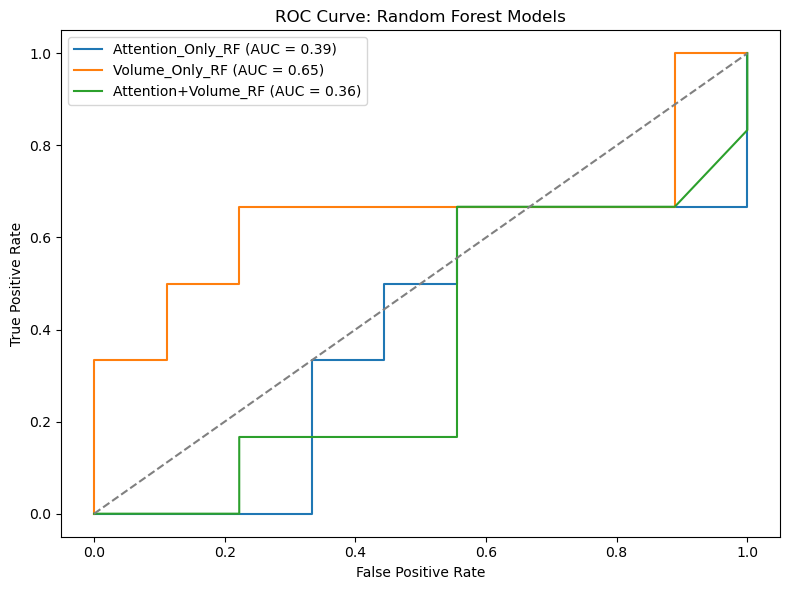

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay

# Prepare storage for results
rf_results = {}

rf_attn = RandomForestClassifier(random_state=42)
rf_attn.fit(Xa_train, ya_train)
y_pred_rf_attn = rf_attn.predict(Xa_test)
y_prob_rf_attn = rf_attn.predict_proba(Xa_test)[:, 1]

rf_results['Attention_Only_RF'] = {
    'Accuracy': accuracy_score(ya_test, y_pred_rf_attn),
    'AUC': roc_auc_score(ya_test, y_prob_rf_attn),
    'y_true': ya_test,
    'y_prob': y_prob_rf_attn,
    'y_pred': y_pred_rf_attn
}

rf_vol = RandomForestClassifier(random_state=42)
rf_vol.fit(Xv_train, yv_train)
y_pred_rf_vol = rf_vol.predict(Xv_test)
y_prob_rf_vol = rf_vol.predict_proba(Xv_test)[:, 1]

rf_results['Volume_Only_RF'] = {
    'Accuracy': accuracy_score(yv_test, y_pred_rf_vol),
    'AUC': roc_auc_score(yv_test, y_prob_rf_vol),
    'y_true': yv_test,
    'y_prob': y_prob_rf_vol,
    'y_pred': y_pred_rf_vol
}

rf_comb = RandomForestClassifier(random_state=42)
rf_comb.fit(Xcm_train, ycm_train)
y_pred_rf_comb = rf_comb.predict(Xcm_test)
y_prob_rf_comb = rf_comb.predict_proba(Xcm_test)[:, 1]

rf_results['Attention+Volume_RF'] = {
    'Accuracy': accuracy_score(ycm_test, y_pred_rf_comb),
    'AUC': roc_auc_score(ycm_test, y_prob_rf_comb),
    'y_true': ycm_test,
    'y_prob': y_prob_rf_comb,
    'y_pred': y_pred_rf_comb
}

plt.figure(figsize=(8, 6))
for label, result in rf_results.items():
    fpr, tpr, _ = roc_curve(result['y_true'], result['y_prob'])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {result['AUC']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve: Random Forest Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig("graphs/rq2_rf_roc_curves.png", dpi=300)
plt.show()

In [44]:
# Extract metrics
rf_summary = {
    model: {'Accuracy': round(res['Accuracy'], 4), 'AUC': round(res['AUC'], 4)}
    for model, res in rf_results.items()
}

# Convert to DataFrame
rf_df = pd.DataFrame.from_dict(rf_summary, orient='index')
print(rf_df)

# Export to CSV
rf_df.to_csv("graphs/rq2_rf_classification_summary.csv")

                     Accuracy     AUC
Attention_Only_RF      0.4667  0.3889
Volume_Only_RF         0.5333  0.6481
Attention+Volume_RF    0.4000  0.3611


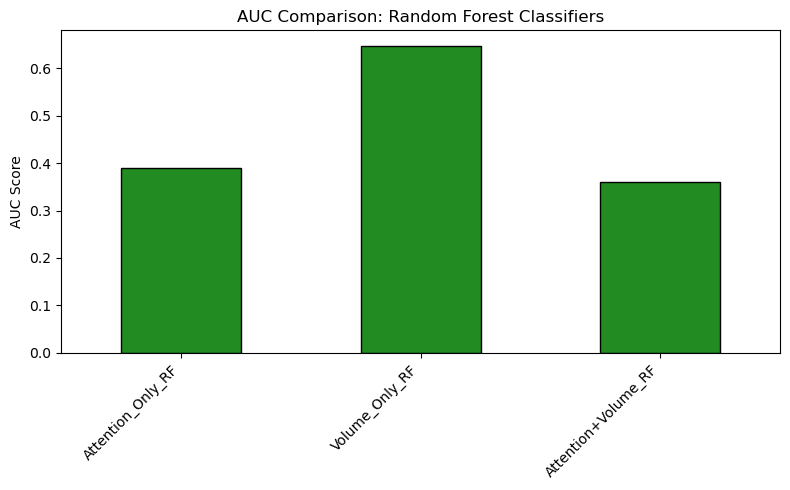

In [48]:
# Make sure rf_df is already created from previous steps
import matplotlib.pyplot as plt
import os

os.makedirs("graphs", exist_ok=True)

plt.figure(figsize=(8, 5))
rf_df['AUC'].plot(kind='bar', color='forestgreen', edgecolor='black')
plt.title("AUC Comparison: Random Forest Classifiers")
plt.ylabel("AUC Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("graphs/rq2_rf_auc_bar_chart.png", dpi=300)
plt.show()

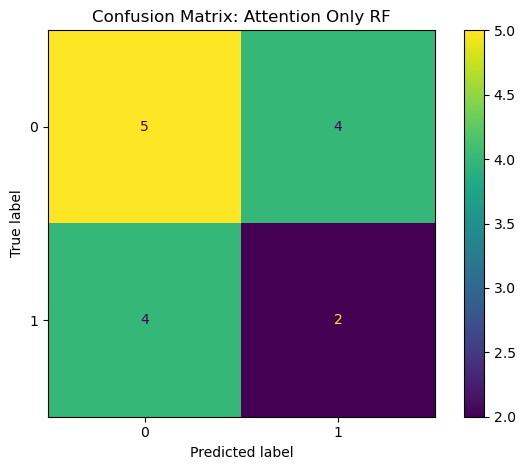

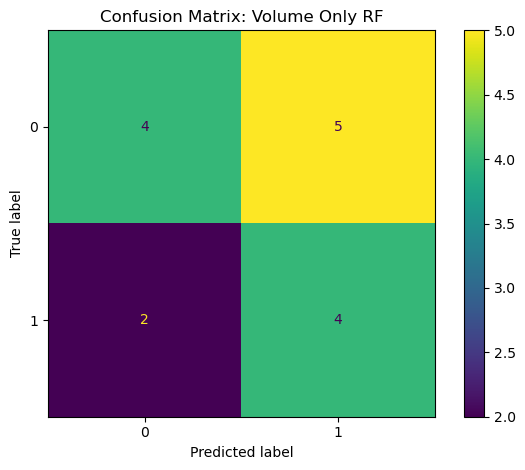

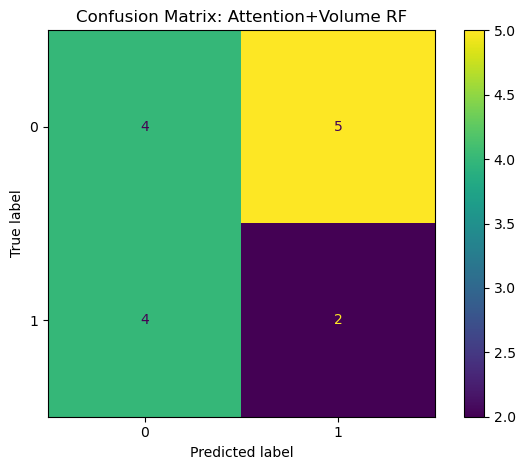

In [47]:
# Ensure output folder
os.makedirs("graphs", exist_ok=True)

# Plot each confusion matrix
for model, res in rf_results.items():
    cm = confusion_matrix(res['y_true'], res['y_pred'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='viridis')
    plt.title(f"Confusion Matrix: {model.replace('_', ' ')}")
    plt.tight_layout()
    filename = model.lower().replace(' ', '_') + "_conf_matrix.png"
    plt.savefig(f"graphs/{filename}", dpi=300)
    plt.show()

### Random Forest vs Logistic Regression: Classification Model Comparison
The application of Random Forest classifiers in this study reveals a more nuanced landscape of predictive performance compared to the earlier linear models. Among the Random Forest models, the Volume-Only model achieves the highest performance with an AUC of 0.6481 and accuracy of 0.5333, outperforming both the Attention-Only and Combined models. This is a notable reversal from the logistic regression results, where the attention-based mode
ls performed marginally better than volume-based predictions.

The improved AUC in the Volume-Only RF model suggests that Random Forest is better able to capture nonlinear relationships and threshold effects within historical volume patterns that linear models could not exploit. Its confusion matrix also reflects a more balanced classification across both classes, avoiding the extreme bias seen in the volume-only logistic regression.

In contrast, the Attention-Only Random Forest model reaches an AUC of 0.3889, which is slightly worse than its linear counterpart (AUC = 0.4444). Similarly, the Combined model (Attention + Volume) fails to improve performance, with an AUC of 0.3611, suggesting that attention data, when added to volume, may introduce noise or overfitting in a small-sample nonlinear setting.

Importantly, despite the Random Forest's theoretical ability to model interactions, the Combined model again fails to outperform simpler alternatives, indicating that the predictive value of attention data may be too weak or unstable in this context. The fact that volume data alone shows the greatest gains when passed through a nonlinear model also underscores that volume patterns may carry richer latent signals than attention scores—at least for predicting the direction of next-week trading activity.



#### Code

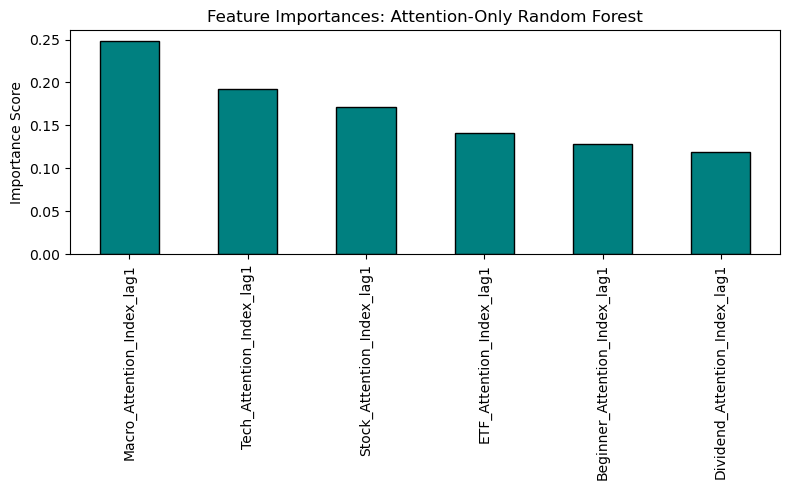

In [49]:
# Extract feature importances
attn_importances = pd.Series(rf_attn.feature_importances_, index=Xa_train.columns)
attn_importances = attn_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
attn_importances.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Feature Importances: Attention-Only Random Forest')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.savefig("outputs/feature_importance_attention_rf.png", dpi=300)
plt.show()


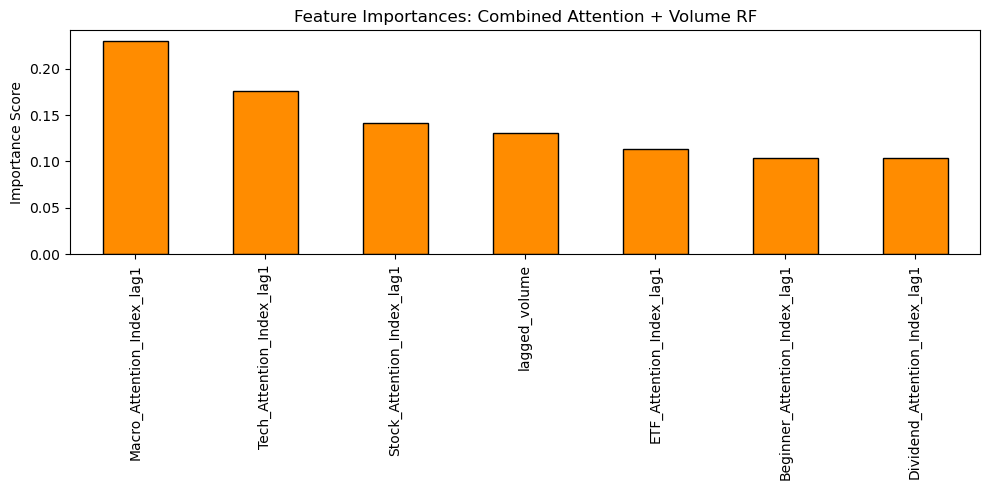

In [50]:
# Extract feature importances
comb_importances = pd.Series(rf_comb.feature_importances_, index=Xcm_train.columns)
comb_importances = comb_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
comb_importances.plot(kind='bar', color='darkorange', edgecolor='black')
plt.title('Feature Importances: Combined Attention + Volume RF')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.savefig("outputs/feature_importance_combined_rf.png", dpi=300)
plt.show()

### Feature Importance Interpretation: Random Forest Models
The Random Forest feature importance plots offer insight into which variables were most influential in predicting next-week trading volume direction. In the Attention-Only RF model, the most predictive feature was the Macro Attention Index, followed closely by Tech and Stock Attention Indexes. This indicates that investors’ search interest in macroeconomic and sector-specific themes may contain relatively stronger signals about future trading activity than general or retail-oriented themes (like beginner or dividend attention), which were less influential.

Interestingly, when we include lagged volume in the Combined Attention + Volume RF model, the attention features continue to dominate the top importance rankings. Macro Attention Index again ranks first, with Tech and Stock Attention Indexes retaining high importance. The lagged volume feature, while somewhat informative, only ranks fourth—suggesting that Random Forest did not find substantial nonlinear patterns in volume alone strong enough to outweigh thematic attention data.

However, this relative ranking should be viewed in light of the overall weak predictive performance of the combined model (AUC = 0.3611). Although attention features appear important within the model structure, the final classification accuracy and AUC remained low. This may reflect overfitting or that no single feature set provided consistently strong signal in the limited-sample, noisy classification context.

In sum, Macro and Tech attention dominate in terms of feature contribution, but their standalone predictive utility remains modest. Their relative prominence suggests potential value in attention segmentation—but also highlights the need for richer or more targeted features to achieve reliable prediction.



## Conclusion: RQ2 – Can Google Trends Data Predict Whether Trading Volume Will Be High Next Week?

The analysis of RQ2 aimed to evaluate whether attention-based signals from Google Trends could predict next-week trading volume direction in financial markets. Across both linear (logistic regression) and nonlinear (random forest) classifiers, the results consistently showed that while attention-related features provided marginal improvements over random guessing, they lacked strong predictive power. In logistic regression, attention-only and combined models achieved modest AUCs (both ~0.44), while volume-only models underperformed (AUC = 0.30), suggesting some linear signal in thematic search interest. However, in the random forest models, the situation reversed: volume-only features performed best (AUC = 0.65), while attention signals failed to add value or even diluted model accuracy.

Feature importance analysis confirmed that certain attention categories—especially macroeconomic and tech-related keywords—held relatively more importance within models, yet this did not translate into meaningful classification gains. The models’ consistently low accuracies and shallow ROC curves underscore the difficulty of using short-lag attention data alone to anticipate directional shifts in trading activity on a week-ahead basis.

In sum, while thematic Google search trends may reflect latent investor sentiment, they do not offer reliable standalone signals for binary prediction of volume surges in the short term. Attention-based data may still hold potential when combined with richer market features, more granular time horizons, or in regression-based frameworks that forecast magnitudes rather than direction. Further research could explore higher-frequency attention dynamics, multi-lag temporal stacking, or hybrid deep learning models to better capture the behavioral-financial linkage.

## Revised Research Question 2 – Can Attention-Based Indicators Predict the Magnitude of Future Trading Volume?
While initial attempts to classify whether next week's trading volume would be “high” or “low” using attention-based signals produced limited predictive performance, the binary framing may have constrained model effectiveness. To better capture the continuous nature of investor behavior and market dynamics, we reformulate RQ2 as a regression problem. Specifically, we ask whether lagged values of thematic attention indexes—derived from Google Trends data—can help predict the magnitude of next-week trading volume. This framing allows us to evaluate the additive forecasting value of attention data relative to traditional market-based features such as lagged volume, and assess their performance through RMSE and visual prediction accuracy over time.